<a href="https://colab.research.google.com/github/sigopt/sigopt-examples/blob/master/xgboost-py-classifier/xgboost_py_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

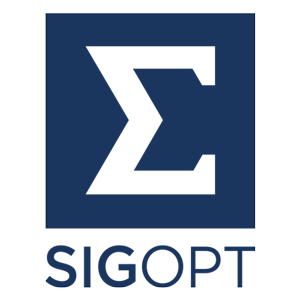

Today I’m going to walk you through training a simple classification model. Although [scikit-learn](https://scikit-learn.org/) and other packages contain simpler models with few parameters ( [SVM](https://scikit-learn.org/stable/modules/svm.html) comes to mind), gradient boosted trees are shown to be very powerful classifiers in a wide variety of datasets and problems. And they happen to benefit massively from hyperparameter tuning. Step by step, I’ll explain how you can use SigOpt to test out multiple hyperparameter configurations in an automated fashion, arriving at a higher accuracy classifier.

[XGBoost](https://xgboost.readthedocs.io/) is one of [the most popular libraries](https://www.docdroid.com/qzyxCr4/kaggle-state-of-data-science-and-machine-learning-2019-pdf) used to pursue classification and regression using machine learning, but without resorting to deep learning techniques, such as neural networks trained in Keras or PyTorch, for example. If you started your journey into data science by comparing different types of regressions or [Naive Bayes](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) classifiers, XGBoost is a wonderful tool to produce more accurate, robust models than even the well-performing [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) found in scikit-learn. XGBoost models should also serve as a baseline against which you should compare state-of-the-art approaches like deep neural networks.

Today we’ll start off with an XGBoost example of a classification model. For a business, this might aid in [fraud detection](https://www.kaggle.com/ntnu-testimon/paysim1), or another way to find outliers, like top customers based on a variety of metrics rather than just one.

## Starting with data:

To keep things simple, we’ll use a standard, cleaned dataset that exists as part of scikit-learn to train our model: the [Wisconsin cancer dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html). It consists of 30 numerical properties (or “features”) that predict whether a certain observation in a scan represents cancer or not, either “malignant” or “benign.” This output representation is the “target” or “label” for each row, representing an individual patient’s outcome.

If you uncomment it, the first line should install a recent version of the XGBoost package from `conda-forge`, in case you don’t have it in your environment already:

In [ ]:
#!conda install -y -c conda-forge xgboost

import pandas as pd
import numpy as np
import seaborn as sns
import time

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, average_precision_score, f1_score
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")  # don't spam the notebook with warnings


If you’re using virtualenv or another Python environment management system, feel free to do a `pip install` instead, or simply insert your own preferred method of installation.

## Setting a baseline:

We’re importing a RandomForestClassifier as a baseline to compare against, and using datasets and metrics functions from scikit-learn. Let’s go ahead and import the sample dataset:

In [ ]:
bc_dataset = load_breast_cancer()
X = pd.DataFrame(bc_dataset.data)
X.columns = bc_dataset.feature_names
y = bc_dataset.target

# Encode string class values as integers to avoid errors in newer versions of XGBoost
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y)
y = label_encoder.transform(y)

# Split data into three parts: 60% train, 20% validation, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1337)

We’ve now separated out our train, test, and validation portions of the original source dataset. This should result in a 60/20/20% split across train, test, and validation rows. Note that we converted the features and the target label into separate dataframes. Your other option is to use `return_X_y=True` or `as_frame=True`, but in my experience these two flags obscured the column names, in case you want to explain parameter importances in your XGBoost model down the line.

In [ ]:
weights = (y == 0).sum() / (1.0 * (y == 1).sum())
weights

0.5938375350140056

With a result of around 0.6, you can see that this dataset isn’t terribly imbalanced. How convenient! Still, we can pass this value into our model to achieve greater accuracy, which we’ll do below.

### An aside, looking at a Random Forest Classifier to compare to a simpler model:

Just so that we reassure ourselves that a simpler and less computationally intensive model won't serve us even better, let's try out a Random Forest Classifier from scikit-learn:

In [ ]:
clf = RandomForestClassifier(max_depth=2, random_state=1337)
clf.fit(X_train, y_train)
accuracy_score(y_test, clf.predict(X_test))

### Now back to a standard xgboost gradient-boosted-machine:

Here we define a baseline, non-tuned model, and then proceed to score it. The specification of a validation set is used by the library to establish a threshold for early stopping so that the model will not continue to train unnecessarily. We’ll use this to compare the full set of our SigOpt-optimized models in a moment. early_stopping_rounds is set to a fairly arbitrary value of 50, but it shouldn’t take more than a minute to run on your machine, a VM, Colab, or [Intel DevCloud](https://software.intel.com/content/www/us/en/develop/tools/devcloud.html).

Now that we’ve established that fitting or training works for this XGBoost model, let’s time the process and leave a few of the parameters at their defaults:

In [ ]:
model = xgb.XGBClassifier(
                          scale_pos_weight = weights,
                          n_jobs = 4,
                          objective='binary:logistic',
                          use_label_encoder = False
                        )
 
start = time.time()
modelfit = model.fit(X_train, y_train, eval_metric='logloss')
fittingTime = time.time() - start
 
start = time.time()
prediction = modelfit.predict(X_test)
InferenceTime = time.time() - start
 
F1score = f1_score(y_test, prediction)
probabilities = modelfit.predict_proba(X_test)
AUPRC = average_precision_score(y_test, probabilities[:, 1])
acc = accuracy_score(y_test, model.predict(X_test))
 
print('AUPRC = {}'.format(average_precision_score(y_test, probabilities[:, 1])))
print('F1 Score = {}'.format(F1score))
print('Fitting Time = {}'.format(fittingTime))
print('Inference Time = {}'.format(InferenceTime))
print('Accuracy = {}'.format(acc))

AUPRC = 0.9938942901403506
F1 Score = 0.9722222222222222
Fitting Time = 0.09770703315734863
Inference Time = 0.001991748809814453
Accuracy = 0.9649122807017544


As you can see, we now have multiple metrics that we can track: AUPRC, F1, fitting time, and inference time. Depending on your use case, these values may make or break your model in production.

## Setting up SigOpt:

Now it’s time to install SigOpt and connect to our API, so be sure to [sign up here for free](http://app.sigopt.com/signup) and add your API key if you choose to run this code yourself:

In [ ]:
# Install SigOpt's client library
!pip install sigopt
import sigopt
 
# Create a connection to SigOpt using either your Development or API token
from sigopt import Connection
 
# put your token here
api_token = "YOUR_API_TOKEN_HERE"
 
conn = Connection(client_token=api_token)

     |████████████████████████████████| 163kB 6.7MB/s 
     |████████████████████████████████| 645kB 13.4MB/s 
     |████████████████████████████████| 655kB 18.0MB/s 
     |████████████████████████████████| 71kB 7.9MB/s 
  Created wheel for pypng: filename=pypng-0.0.20-cp37-none-any.whl size=67163 sha256=55f03f36afb8aa826b40683cd904f5f64b0e540f7afdc20dfcbbf2c5501e20c8
  Stored in directory: /root/.cache/pip/wheels/41/6b/ef/0493b536b6d4722c2ae9486691b1d49b922b9877922beeabb3
Successfully built pypng
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Now that we’ve established our connection to SigOpt, it’s time to define the functions that create and evaluate our model:

In [ ]:
def create_model(assignments):
    model = xgb.XGBClassifier(
        min_child_weight = assignments['min_child_weight'],
        max_depth        = assignments['max_depth'],
        gamma            = assignments['gamma'],
        subsample        = assignments['subsample'],
        colsample_bytree = assignments['colsample_bytree'],
        reg_lambda       = np.exp(assignments['lambda']),
        reg_alpha        = np.exp(assignments['alpha']),
        learning_rate    = np.exp(assignments['log_learning_rate']),
        scale_pos_weight = weights,
        n_jobs = 4)
    return model
  
def evaluate_model(assignments):
    model = create_model(assignments)
    probabilities = model.fit(X_train, y_train).predict_proba(X_test)
    AUPRC = average_precision_score(y_test, probabilities[:, 1])
    return AUPRC

Note that we’ll be tuning 8 different parameters in this model. This would be resource intensive for grid search and even random search to sweep. But with Bayesian optimization and other global algorithms in SigOpt, we can run this hyperparameter optimization job efficiently. You can also see that we pass the `scale_pos_weight` value, which is generated based on the dataset, as well as the number of threads we want to use in the `n_jobs` parameter; these are both fixed. You can increase `n_jobs` if your processor supports more than 4 threads.

Now it’s time to configure the SigOpt experimentation loop, including its metrics, the parameters you want to test, and their bounds (minimum and maximum):

In [ ]:
experiment = conn.experiments().create(
    
    name="Cancer Prediction XGB - Vanilla SigOpt",
 
    parameters=[
        dict(name="min_child_weight", bounds=dict(min=2,max=15), type="int"),
        dict(name="max_depth", bounds=dict(min=3,max=10), type="int"),
        dict(name="gamma", bounds=dict(min=0,max=5), type="double"),
        dict(name="subsample", bounds=dict(min=0.5,max=1), type="double"),
        dict(name="colsample_bytree", bounds=dict(min=0.5,max=1), type="double"),
        dict(name="lambda", bounds=dict(min=0.00001, max=1), type="double", transformation="log"),
        dict(name="alpha", bounds=dict(min=0.00001, max=1), type="double", transformation="log"),
        dict(name="log_learning_rate", bounds=dict(min=0.00001 ,max=1), type="double", transformation="log")
        ],
 
    metrics=[
        dict(name="AUPRC", objective="maximize", strategy="optimize")
        ],
 
    observation_budget = 120,
)
 
print("Explore your experiment: https://app.sigopt.com/experiment/" + experiment.id + "/analysis")

Explore your experiment: https://app.sigopt.com/experiment/388787/analysis


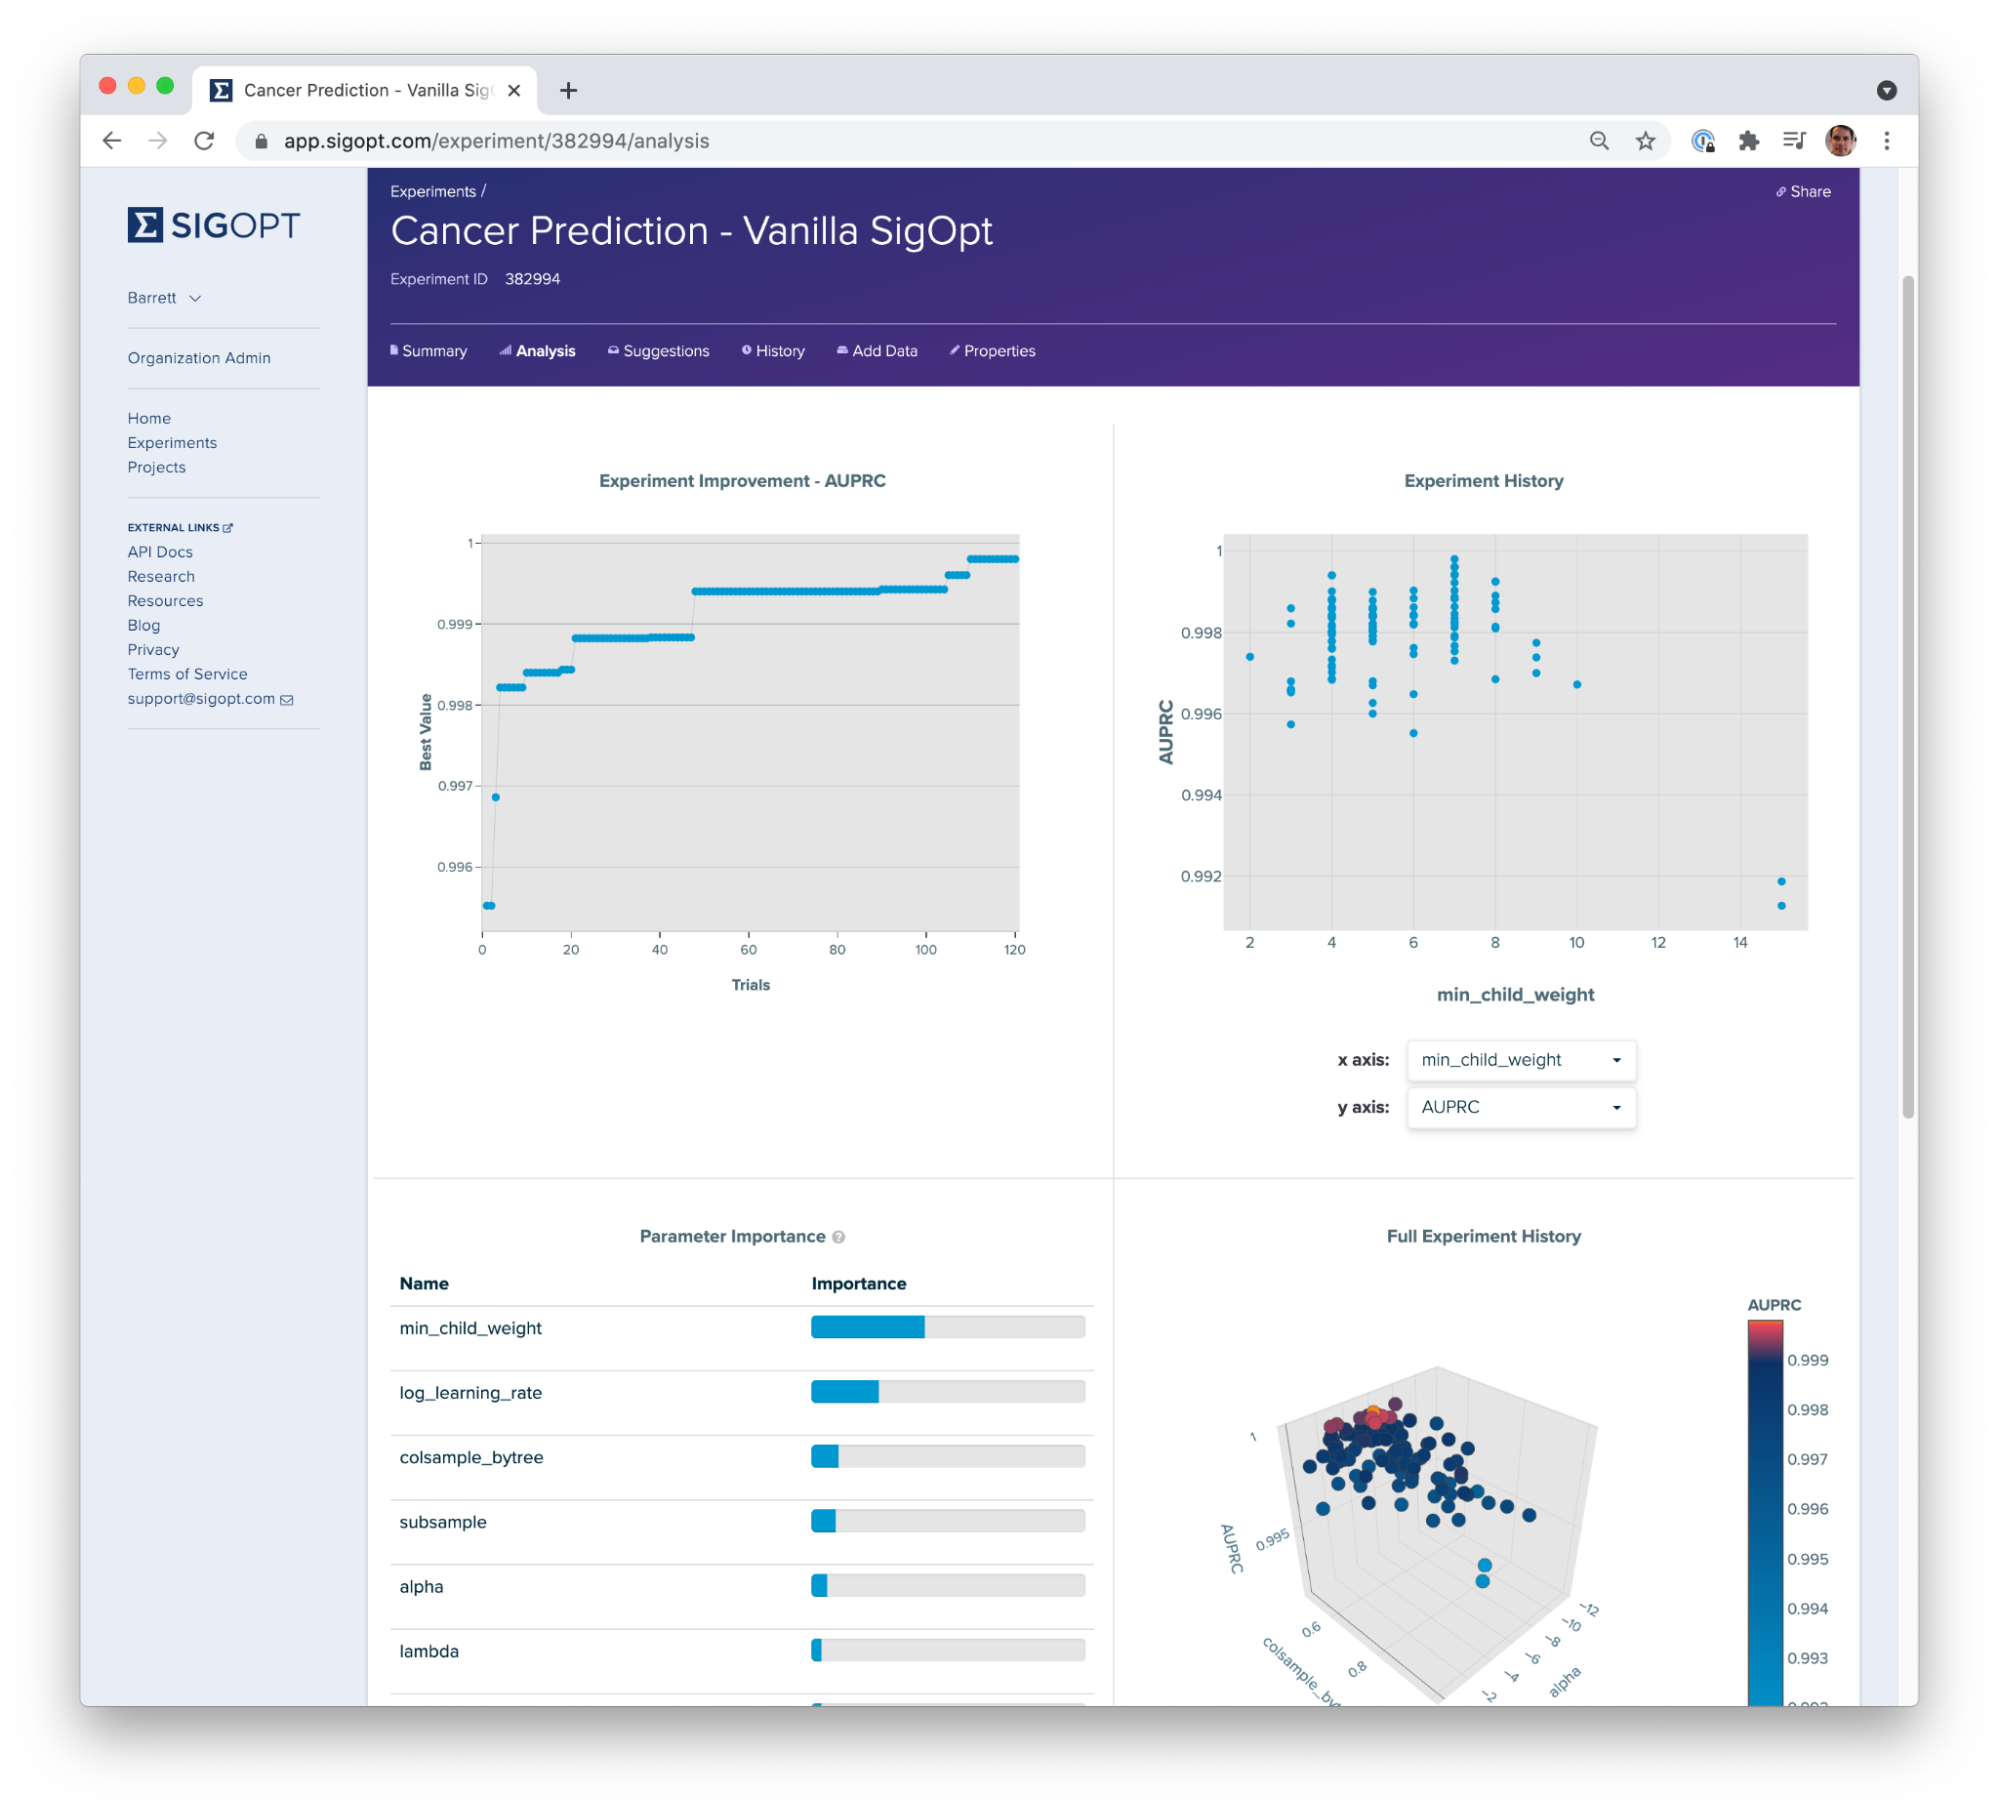

We use a much higher `observation_budget` here, not only to get better results, but also because this is a relatively fast-training model on a relatively small dataset. You can visit the link output by the above cell, but you won’t see any data until you run the following code block to actually execute the experiment loop you just set up:


In [ ]:
#Optimization Loop
for _ in range(experiment.observation_budget):
    suggestion = conn.experiments(experiment.id).suggestions().create()
    assignments = suggestion.assignments
    value = evaluate_model(assignments)
 
    conn.experiments(experiment.id).observations().create(
        suggestion=suggestion.id,
        values=[dict(name="AUUPRC", value=value)]
    )
    
    #update experiment object
    experiment = conn.experiments(experiment.id).fetch()
 
assignments = conn.experiments(experiment.id).best_assignments().fetch().data[0].assignments  
 
print("BEST ASSIGNMENTS FOUND: \n", assignments)

BEST ASSIGNMENTS FOUND: 
 Assignments({
  "alpha": 1.0,
  "colsample_bytree": 0.5,
  "gamma": 0.0,
  "lambda": 0.24122892509577215,
  "log_learning_rate": 1e-05,
  "max_depth": 9,
  "min_child_weight": 6,
  "subsample": 0.661140485959017
})


At the bottom of your notebook or interpreter’s output, you should see the best set of parameters SigOpt was able to find in 120 automated training runs.

### Background on XGBoost’s parameters:

* `min_child_weight`, used to control over-fitting, this parameter is the sample size under which the 
model can not split a node. Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree.
* `max_depth`, this is the maximum depth of a tree. This parameter controls over-fitting as higher depth will allow the model to learn relations very specific to a particular sample.
* `gamma`, this parameter specifies the minimum loss reduction required to make a split. The larger gamma is, the more conservative the algorithm will be.
subsample, defines the ratio of the training instances. For example setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees, preventing overfitting
* `colsample_bytree`, defines the fraction of features to be randomly sampled for each tree.
alpha and lambda are the L1 and L2 regularization terms on weights. Both values tend to prevent overfitting as they are increased. Additionally, Alpha can be used in case of very high dimensionality to help a model training converge faster
* `learning_rate` controls the weighting of new trees added to the model. Lowering this value will prevent overfitting, but require the model to add a larger number of tree


## Wrapping up:
While we explored classification today on a toy dataset, you can also apply these techniques to [fraud detection](https://www.kaggle.com/arjunjoshua/predicting-fraud-in-financial-payment-service), predictive maintenance, or a number of other applications in which you want to classify an outcome based on many numerical features. As in the fraud detection example, your application may require extensive data cleaning, which you’ll have to account for on your own. But once you’ve cleaned and prepped your data, you can easily see how SigOpt facilitates a robust, efficient, and well-tracked experimentation process. Aside from ease-of-use, SigOpt delivers much better optimization performance, when compared with human-tuned parameters or an exhaustive approach like grid search. If you’d like, you can find the original iPython Jupyter Notebook code for this example here, or you can run it on Colab here. Next time we’ll explore a regression problem on a slightly larger dataset.